In [27]:
import os
import subprocess
from pathlib import Path

"""
Dynamically find the project root (where .git exists) and set it as the current working directory.
"""
project_root = Path(subprocess.check_output(['git', 'rev-parse', '--show-toplevel'], text=True).strip())
os.chdir(project_root)

In [28]:
import pandas as pd

from src.questions.styleClustering.K_mean_cluster import run_clustering




In [29]:
#BA_US_knn_text = pd.read_csv('data/knnData/BA_US_knn_text.csv')

#run_clustering(BA_US_knn_text)

In [30]:
#RB_US_knn_text = pd.read_csv('data/knnData/RB_US_knn_text.csv')

#run_clustering(RB_US_knn_text)

In [31]:
#UMAP clustering
from src.questions.styleClustering.utils.prepData import prep_data
BA_US_knn_text = pd.read_csv('data/knnData/BA_US_knn_text.csv')
df_total_clustering, states = prep_data(BA_US_knn_text)


In [42]:
BA_US_knn_text.head(5)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,user_id,appearance,aroma,palate,taste,overall,rating,text,avg,user_state,beer_state
0,Kupfer Kolsch,289320.0,Copper State Brewing Company,49595.0,Kölsch,4.4,n2185.211743,2.50,4.00,4.00,3.75,3.75,3.76,NaN,3.76,North Carolina,Wisconsin
1,Northwestern Alt,289321.0,Copper State Brewing Company,49595.0,Altbier,4.6,n2185.211743,3.00,3.75,4.00,3.50,3.50,3.58,NaN,3.58,North Carolina,Wisconsin
2,One Cent Wheat,289319.0,Copper State Brewing Company,49595.0,Witbier,5.4,n2185.211743,3.75,3.25,3.75,3.50,3.50,3.48,NaN,3.48,North Carolina,Wisconsin
3,Platinum Coffee Blonde,289324.0,Copper State Brewing Company,49595.0,American Blonde Ale,7.3,n2185.211743,3.25,3.75,3.50,4.25,4.25,4.00,NaN,4.02,North Carolina,Wisconsin
4,Platinum Coffee Blonde,289324.0,Copper State Brewing Company,49595.0,American Blonde Ale,7.3,angerhaus.1049226,4.00,4.25,3.75,4.00,4.00,4.04,NaN,4.02,Wisconsin,Wisconsin


In [32]:
import umap
import pandas as pd
import plotly.express as px
from sklearn.cluster import DBSCAN
import geopandas as gpd

# Step 1: Drop the 'user_state' column as it's just an identifier and not used for UMAP
df_total_clustering_cleaned = df_total_clustering.drop(columns=['user_state'])

print(df_total_clustering_cleaned.shape)
# Fill NaN values with 0
df_cleaned = df_total_clustering_cleaned.fillna(0)

# Apply UMAP to reduce dimensions to 3
umap_3d = umap.UMAP(n_components=3, random_state=42)
embedding_3d = umap_3d.fit_transform(df_cleaned)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.65, min_samples=3)  # Tune eps and min_samples for better clustering
dbscan_labels = dbscan.fit_predict(embedding_3d)

# Add the cluster labels back to the dataframe
df_cleaned['Cluster'] = dbscan_labels
df_cleaned['user_state'] = df_total_clustering['user_state']  # Assuming original_df has 'user_state'

# Define a consistent color map for clusters
cluster_color_map = {
    '0': "#3498DB",  # Sky Blue
    '1': "#F1C40F",  # Gold
    '2': "#E74C3C",  # Tomato Red
    '3': "#2ECC71",  # Emerald Green
    '4': "#9B59B6",  # Amethyst Purple
    '5': "#1F618D"   # Deep Blue
}

# Convert DBSCAN labels to a string format for Plotly (optional for cleaner hover info)
df_cleaned['Cluster'] = df_cleaned['Cluster'].astype(str)

# Plot the 3D UMAP with Plotly
fig = px.scatter_3d(
    df_cleaned,
    x=embedding_3d[:, 0],
    y=embedding_3d[:, 1],
    z=embedding_3d[:, 2],
    title="DBSCAN Clustering on UMAP",
    labels={'Cluster': 'Cluster Label'},
    hover_data={'user_state': True, 'Cluster': False},  # Only show user_state on hover, hide Cluster
    color = 'Cluster',
    color_discrete_map=cluster_color_map  # Apply custom colors
)

fig.show()



# Draw the map with consistent colors


(50, 824)


c:\Users\iaran\miniconda3\envs\ada\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [33]:
import pandas as pd
import plotly.express as px


def draw_map(df_cleaned):
    # Step 1: Define a mapping for state abbreviations
    state_to_abbr = {
        'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
        'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
        'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
        'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
        'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
        'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
        'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
        'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
        'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
        'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
    }

    # Step 2: Merge df_cleaned with state abbreviations
    df_cleaned['state_abbreviation'] = df_cleaned['user_state'].map(state_to_abbr)

    # Step 3: Convert Cluster to string to match keys in cluster_color_map
    df_cleaned['Cluster'] = df_cleaned['Cluster'].astype(str)

    # Step 4: Plot the choropleth map
    fig = px.choropleth(
        df_cleaned, 
        locations='state_abbreviation', 
        color='Cluster', 
        color_discrete_map=cluster_color_map,  # Apply the custom color map
        title="USA State Clusters Based on DBSCAN",
        locationmode="USA-states",
        hover_name='user_state',  # Hover shows the state name
        hover_data={'user_state': False, 'Cluster': False, 'state_abbreviation': False}  # Optional: Hide some data on hover
    )

    fig.update_layout(
        geo_scope='usa',
        width=900,  # Adjust width
        height=600,  # Adjust height
        title_font=dict(size=20),
        geo=dict(projection_type="albers usa")
    )

    fig.show()

# Call the function to draw the map
draw_map(df_cleaned)


Analysis on the clusters- feature analysis

In [36]:
df_cleaned.head(3)

,Altbier_avg_appearance,Altbier_avg_aroma,Altbier_avg_palate,Altbier_avg_taste,Altbier_avg_overall,Altbier_avg_rating_per_style,Altbier_std_per_style,Altbier_normalised_review_count,American Adjunct Lager_avg_appearance,American Adjunct Lager_avg_aroma,...,Witbier_avg_aroma,Witbier_avg_palate,Witbier_avg_taste,Witbier_avg_overall,Witbier_avg_rating_per_style,Witbier_std_per_style,Witbier_normalised_review_count,Cluster,user_state,state_abbreviation
0,4.058824,3.735294,3.764706,3.911765,3.955882,3.745882,0.252365,0.001860,2.879412,2.608824,...,3.573171,3.474085,3.429878,3.568598,3.557256,0.282003,0.017947,0,Alabama,AL
1,3.869048,3.559524,3.583333,3.642857,3.738095,3.695714,0.217499,0.004418,2.973404,2.707447,...,3.723881,3.817164,3.798507,3.902985,3.763881,0.251342,0.014096,1,Alaska,AK
2,3.677326,3.500000,3.546512,3.587209,3.622093,3.671395,0.213167,0.004316,3.019345,2.586310,...,3.574773,3.552870,3.559668,3.577795,3.568489,0.329566,0.016610,0,Arizona,AZ


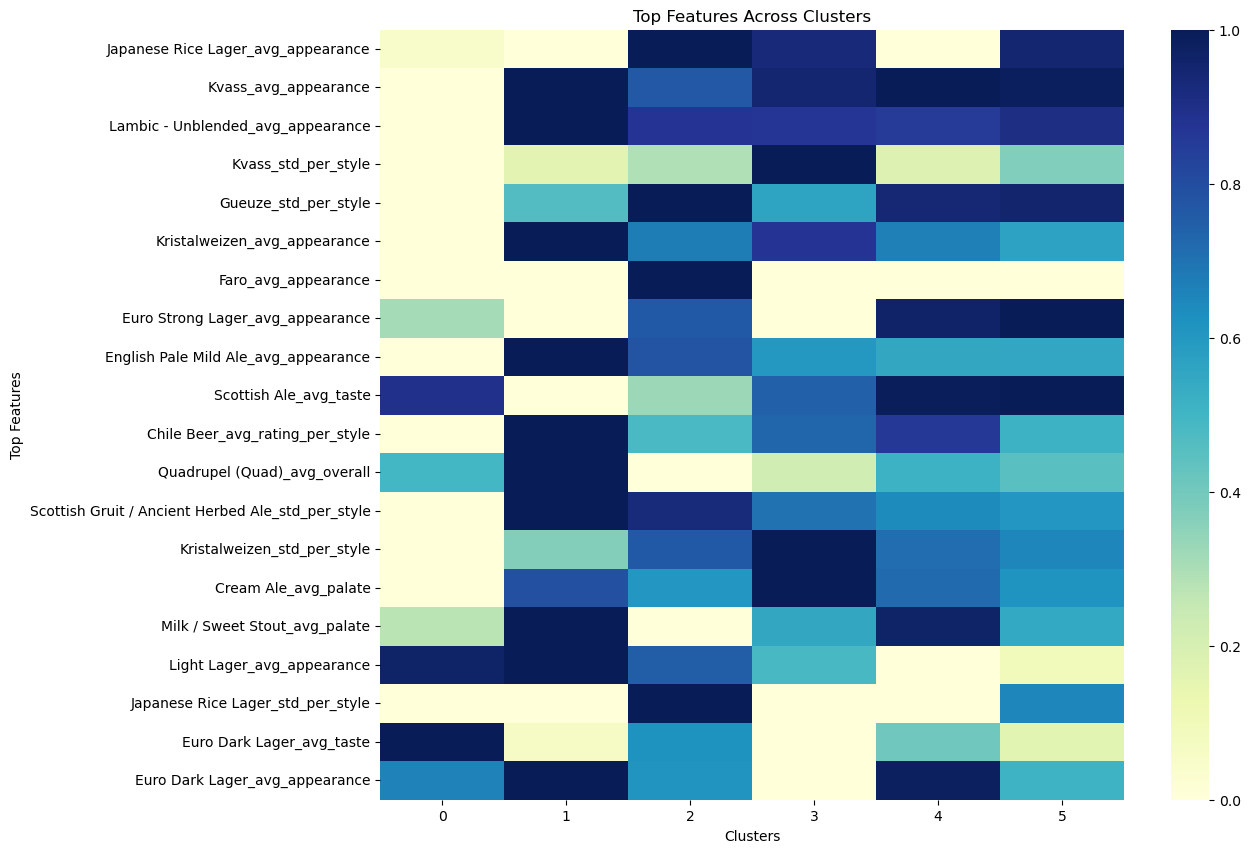

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier

# 1. Feature Selection: Variance Filtering
# -----------------------------------------------------
# Assuming your DataFrame is named 'df' with a 'cluster' column
X = df_cleaned.drop(columns=['Cluster', 'user_state', 'state_abbreviation'])  # Features
y = df_cleaned['Cluster']  # Target (clusters)

# Step 1: Remove low-variance features
selector = VarianceThreshold(threshold=0.01)  # Threshold can be adjusted
X_filtered = pd.DataFrame(selector.fit_transform(X), columns=X.columns[selector.get_support()])

# Step 2: Remove highly correlated features
corr_matrix = X_filtered.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
X_filtered = X_filtered.drop(columns=to_drop)

# Step 3: Feature Importance using Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_filtered, y)

# Get top N important features
feature_importances = pd.Series(model.feature_importances_, index=X_filtered.columns)
top_features = feature_importances.nlargest(20).index  # Adjust '20' for desired number of features

# 2. Plot the Heatmap with Top Features
# -----------------------------------------------------
# Combine top features with cluster labels
top_features_df = pd.concat([X_filtered[top_features], y], axis=1)

# Group by cluster and calculate the mean for each feature
cluster_means = top_features_df.groupby('Cluster').mean()

# Normalize for better visualization
cluster_means_normalized = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cluster_means_normalized.T, cmap="YlGnBu", annot=False)

plt.title("Top Features Across Clusters")
plt.xlabel("Clusters")
plt.ylabel("Top Features")
plt.show()


Top 20 Most Variant Features with at least 5000 Reviews Total:
Series([], dtype: float64)


IndexError: index 0 is out of bounds for axis 0 with size 0

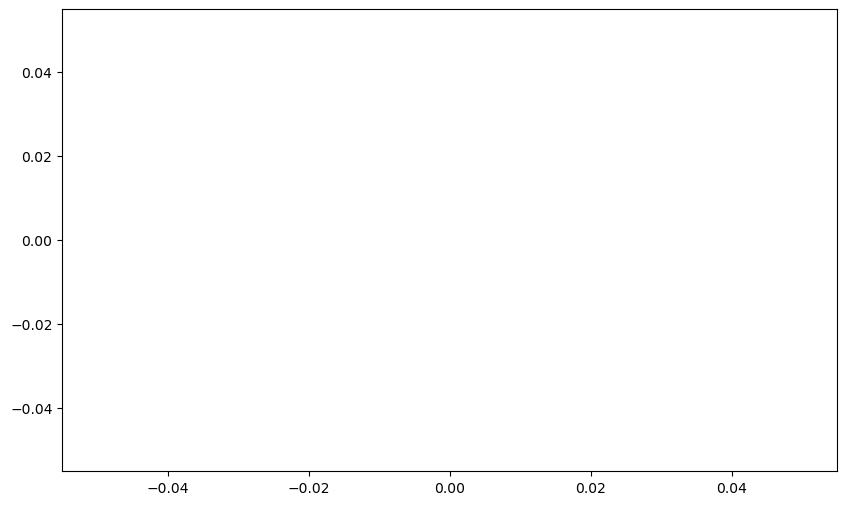

In [54]:
# Step 1: Count the number of reviews for each style in BA_US_knn_text
style_review_counts = BA_US_knn_text['style'].value_counts()

# Step 2: Filter styles with at least 5000 reviews
valid_styles = style_review_counts[style_review_counts >= 10].index

# Step 3: Retain only valid styles in df_cleaned
filtered_features = df_cleaned[valid_styles.intersection(df_cleaned.columns)]

# Step 4: Calculate variance for these features
variances = filtered_features.var()

# Step 5: Select the top 20 features with the highest variance
top_20_variance_features = variances.nlargest(20)

# Output the results
print("Top 20 Most Variant Features with at least 5000 Reviews Total:")
print(top_20_variance_features)

# Step 6: Visualize the results
top_20_variance_features.plot(kind='barh', figsize=(10, 6), color='teal')
plt.title("Top 20 Most Variant Features (At Least 5000 Reviews Total)")
plt.xlabel("Variance")
plt.ylabel("Feature")
plt.show()
